In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sbn

from sklearn.preprocessing import PolynomialFeatures

from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, r2_score,roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.svm import LinearSVC 
from sklearn.metrics import SCORERS, balanced_accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE


import matplotlib.pyplot as plt
from matplotlib import itertools

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_curve

pd.set_option('max_columns', 100)
import multiprocessing

# Методы

In [2]:
# Метод для отрисовки Bar.
def plot_feat(data):
    h = pd.DataFrame(data.T.tolist())
    h.columns = h.iloc[0,:]
    h.drop(0, axis=0, inplace=True)
    sbn.barplot(data=h, orient='h')

    

# Метод для извлечения главных признаков.
def importance_feat (model, data, labels, key, into = False):
    feature = []
    X_train = StandardScaler().fit_transform(data)
    model.fit(X_train, labels)
    key = (key)
    if into:
        for name, score in zip(data.columns, getattr(model, key)[0]):
            feature.append([name, np.round(score, 2)])
    else:
         for name, score in zip(data.columns, getattr(model, key)):
            feature.append([name, np.round(score, 2)])
    return np.sort(feature,axis = 0)[::-1]



# Метод для отрисовки матрицы ошибок.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Матрица ошибок',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=20)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# Считываем данные из Excel.
download_data = pd.read_excel('C:/Users/ArtemProdaction/Desktop/SAP/Company_HR_Employees.xlsx',sheet_name='HR-Employee-Info', header=0)

In [4]:
# Смотрим начало.
download_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,34,No,Travel_Rarely,628,Research & Development,8,3,Medical,2068,2,Male,82,4,2,Laboratory Technician,3,Married,4404,10228,2,Y,No,12,3,1,80,0,6,3,4,4,3,1,2
1,49,No,Travel_Frequently,1023,Sales,2,3,Medical,2065,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,Y,No,14,3,4,80,0,17,3,2,9,6,0,8
2,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3
3,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
4,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3


In [5]:
# Смотрим конец.
download_data.tail()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1465,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
1466,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
1467,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
1468,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
1469,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5


In [6]:
# Проверяем пропуски (к счастью их нет), данные премущественно int64.
download_data.info(max_cols=True, verbose=1,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 34 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome               1470 non-null int64
MonthlyRate           

In [7]:
# Различные характеристики для числовых признаков.
download_data.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


# Исследуем данные

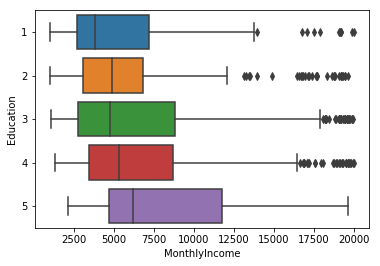

In [8]:
# Мы видим на эитх boxsplot-ах, что образование (особенно докторская степень) - это важно :)
top_platforms = download_data.Age.value_counts().sort_values(ascending = False).index.values
sbn.boxplot(y="Education", x="MonthlyIncome", data=download_data[download_data.Age.isin(top_platforms)], orient="h")

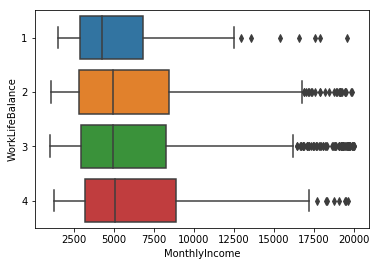

In [9]:
# Мы видим на эитх boxsplot-ах, что, чем больше ежемесячный доход, тем лучше человек познает дзен (или наоборот).
# Хоть это и очень натянуто.
top_platforms = download_data.Age.value_counts().sort_values(ascending = False).index.values
sbn.boxplot(y="WorkLifeBalance", x="MonthlyIncome", data=download_data[download_data.Age.isin(top_platforms)], orient="h")

In [10]:
# Также полезно будет знать, различные соотношения данных.
for feature in ['Attrition', 'BusinessTravel', 'Department', 'Education', 'EducationField','EnvironmentSatisfaction',
               'Gender', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'NumCompaniesWorked', 'OverTime',
                'PerformanceRating', 'MaritalStatus']:
    print(download_data[feature].value_counts(normalize = False), '\n')

No     1233
Yes     237
Name: Attrition, dtype: int64 

Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64 

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64 

3    572
4    398
2    282
1    170
5     48
Name: Education, dtype: int64 

Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64 

3    453
4    446
2    287
1    284
Name: EnvironmentSatisfaction, dtype: int64 

Male      882
Female    588
Name: Gender, dtype: int64 

Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: JobRol

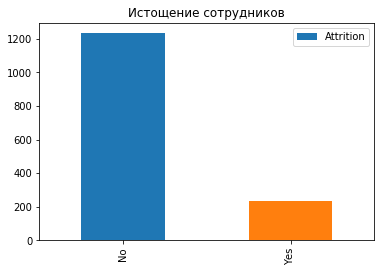

In [11]:
# Самое главное разочарование для нас, так это то, что целевой признак плохо сбалансирован.
download_data['Attrition'].value_counts().plot(kind='bar', label='Attrition')
plt.legend()
plt.title('Истощение сотрудников');

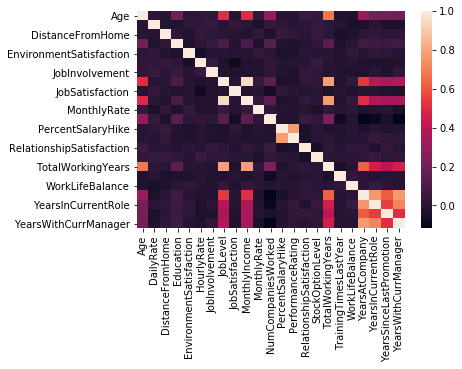

In [12]:
# Посмотрим на различные зависимости (интересные и не очень).
# Сделаем выборку признаков специально для корреляции.

data_for_corr = download_data.drop(['Gender','Attrition', 'Over18','StandardHours', 'EmployeeNumber'], axis=1)
data_for_corr = pd.get_dummies(data_for_corr)

data_for_corr = data_for_corr.loc[:, :'YearsWithCurrManager']

sbn.heatmap(data_for_corr.corr(method='pearson'))

In [13]:
# Признаки с сильной корреляцией.
for coef_depend in data_for_corr.columns:
    dep =  list(data_for_corr.columns[np.abs(data_for_corr.corr(method='pearson')[coef_depend]) > 0.7 ])
    if len(dep)>1:
        print('{0} имеет зависимость: '.format(coef_depend), dep)

JobLevel имеет зависимость:  ['JobLevel', 'MonthlyIncome', 'TotalWorkingYears']
MonthlyIncome имеет зависимость:  ['JobLevel', 'MonthlyIncome', 'TotalWorkingYears']
PercentSalaryHike имеет зависимость:  ['PercentSalaryHike', 'PerformanceRating']
PerformanceRating имеет зависимость:  ['PercentSalaryHike', 'PerformanceRating']
TotalWorkingYears имеет зависимость:  ['JobLevel', 'MonthlyIncome', 'TotalWorkingYears']
YearsAtCompany имеет зависимость:  ['YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager']
YearsInCurrentRole имеет зависимость:  ['YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager']
YearsWithCurrManager имеет зависимость:  ['YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager']


# Преобразование данных

In [14]:
data = download_data.copy()

# Кодируем наши данные
d = {'No' : 0, 
     'Yes' : 1}

data['Attrition'] = data['Attrition'].map(d)
data['OverTime'] = data['OverTime'].map(d)

d = {'Female' : 0, 
     'Male' : 1}

data['Gender'] = data['Gender'].map(d)

# Избавимся от неинформативных признаков.
data.drop(['Over18','StandardHours', 'EmployeeNumber'], axis = 1, inplace=True)

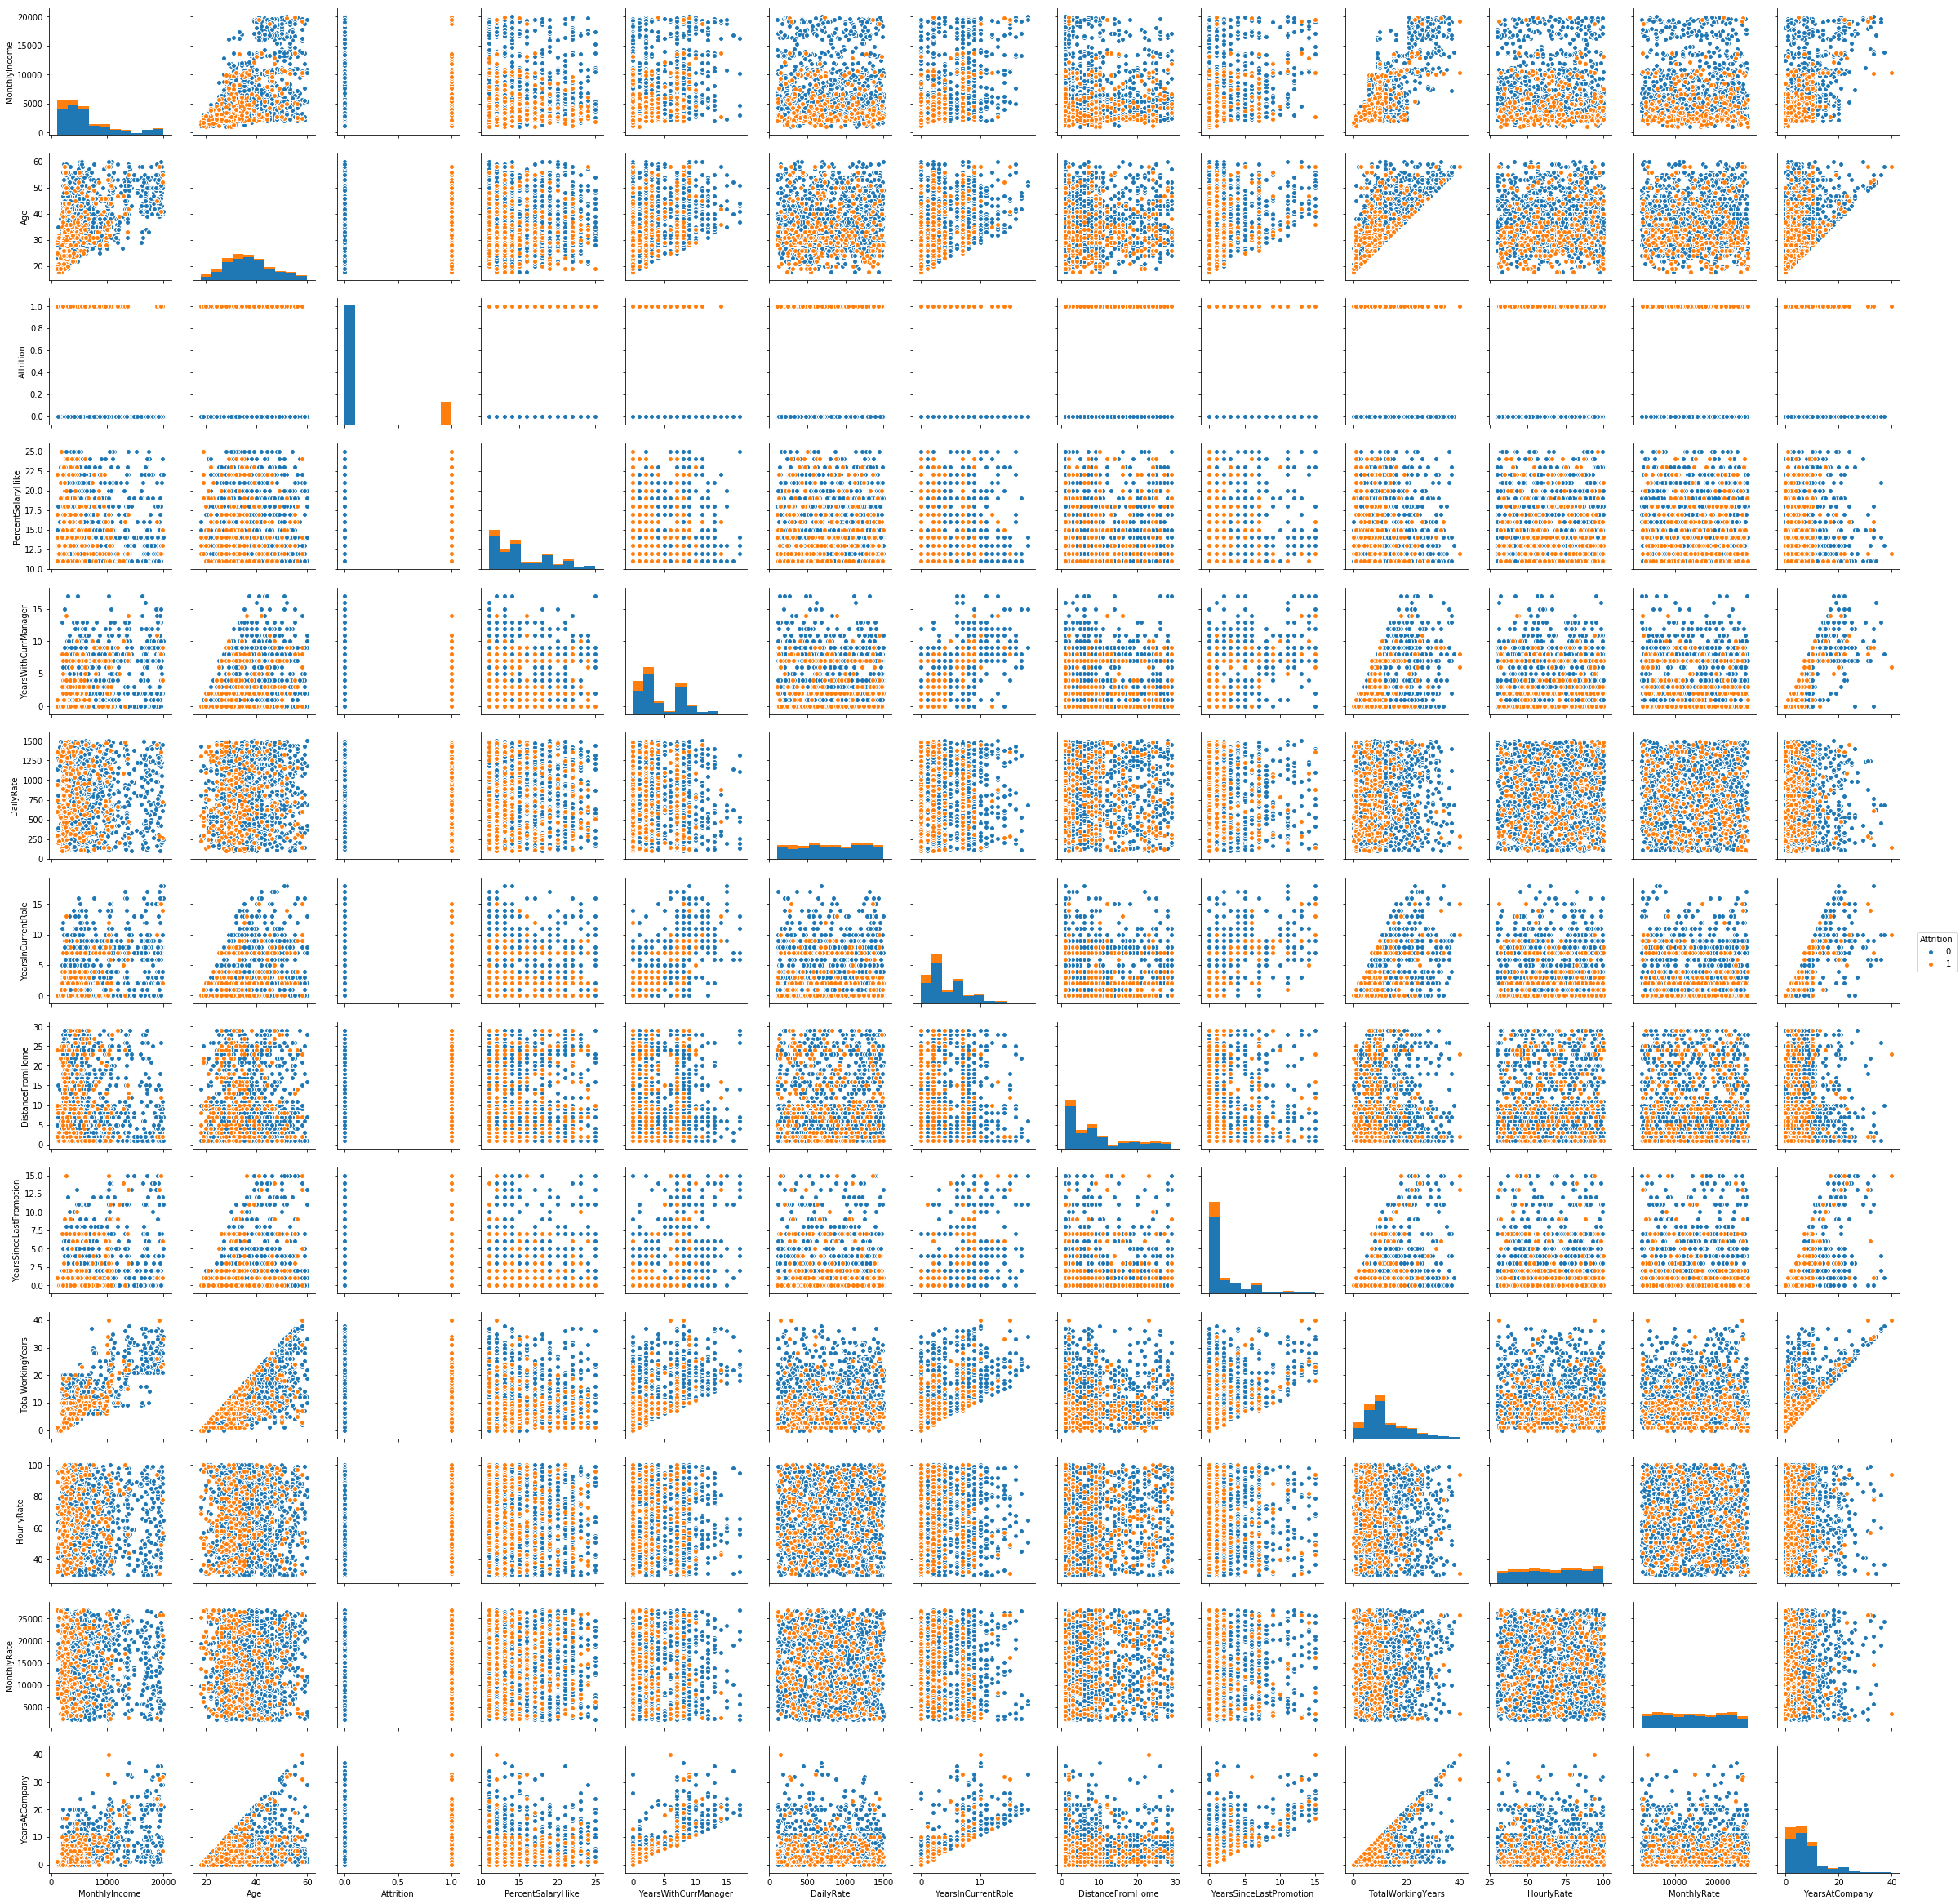

In [15]:
# Парные отношения категориальных признаков по целевой переменной.
features = list(set(data.columns) - set(['BusinessTravel', 
                                         'Department', 
                                         'Education', 
                                         'EducationField',
                                         'EnvironmentSatisfaction',
                                        'Gender', 
                                         'JobRole', 
                                         'JobSatisfaction', 
                                         'MaritalStatus', 
                                         'NumCompaniesWorked', 
                                         'OverTime',
                                         'PerformanceRating', 
                                         'MaritalStatus', 
                                         'JobInvolvement', 
                                         'JobLevel',
                                        'StockOptionLevel', 
                                         'RelationshipSatisfaction', 
                                         'TrainingTimesLastYear', 
                                         'WorkLifeBalance']))

sbn.pairplot(data[features], hue='Attrition');

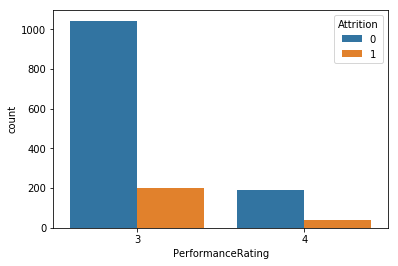

In [16]:
# Как мы видели выше, данные разделены очень плохо, не считая некоторых исключений.
# Для примера, продемонстрируем признак, который позволяет достичь 74% accuracy.
# Среди тех у кого 'PerformanceRating'==4, гораздо меньше людей, которые не ушли в отставку.
# В соотношении 189/1044 = 0.18. Т.о. говоря, что те, у кого 'PerformanceRating'==3, у того 'Attrition == 0,
# а с PerformanceRating'==4 равен 1, будут "правы" на  74% (1044+37)/(1044+200+189+37) ~ 0.74).

sbn.countplot(x='PerformanceRating', hue='Attrition', data=data);

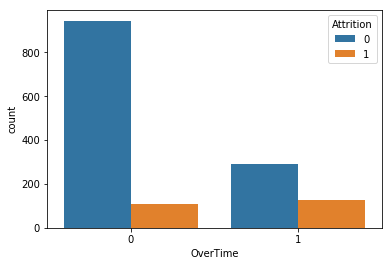

In [17]:
# Тоже самое и с 'OverTime'.
sbn.countplot(x='OverTime', hue='Attrition', data=data);

# Построение модели (Attrition)

In [18]:
# Так как линейные модели лучше работают, с разреженными данными, то сделаем one-hot кодирование.
# Делим данные на предиктовные и целевые.

labels = data['Attrition']
data_attr = data.drop('Attrition', axis=1)

data_log = data_attr.copy()
data_log = pd.get_dummies(data_log)

# Избавляемся от коллинеарности.
data_log.drop(['YearsAtCompany', 
               'YearsInCurrentRole', 
               'Age', 'JobLevel', 
               'MonthlyIncome'], 
              axis=1, inplace=True)

# Логистическая регрессия

In [19]:
# Naive random over-sampling и подбор параметров.
ros = RandomOverSampler(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(data_log, labels, test_size=0.3, shuffle=True, random_state=241)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

grid = {'C': [0.1, 1, 5, 10, 20, 50], 
        'solver':['newton-cg', 'lbfgs']}

model_log = LogisticRegression(random_state=241, n_jobs=multiprocessing.cpu_count())

cv = KFold(n_splits=5, shuffle = True, random_state=241)
gs = GridSearchCV(model_log, grid, scoring='balanced_accuracy', cv=cv)

gs.fit(X_resampled, y_resampled)

print(gs.best_params_)

{'C': 10, 'solver': 'newton-cg'}


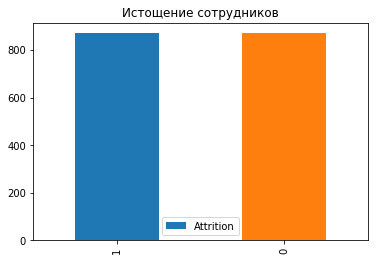

In [20]:
# Разочарование ушло, так как выборка стала сбалансированной. 
pd.Series(y_resampled).value_counts().plot(kind='bar', label='Attrition')
plt.legend()
plt.title('Истощение сотрудников');

In [21]:
# Обучение логистической регрессии.
model_log = LogisticRegression(C=10, solver='newton-cg')
model_log.fit(X_resampled, y_resampled)

print(classification_report(y_test, model_log.predict(X_test)))
print('roc_auc:', roc_auc_score(y_test, model_log.predict_proba(X_test)[:,1]))
print('balanced accuracy:', balanced_accuracy_score(y_test, model_log.predict(X_test)))
print(np.bincount(y_test))

D:\AnacondaP2\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\AnacondaP2\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\AnacondaP2\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\AnacondaP2\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\AnacondaP2\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


              precision    recall  f1-score   support

           0       0.95      0.79      0.86       362
           1       0.45      0.80      0.58        79

   micro avg       0.79      0.79      0.79       441
   macro avg       0.70      0.79      0.72       441
weighted avg       0.86      0.79      0.81       441

roc_auc: 0.8328204769564305
balanced accuracy: 0.7923805860549689
[362  79]


D:\AnacondaP2\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


Confusion matrix, without normalization
[[285  77]
 [ 16  63]]


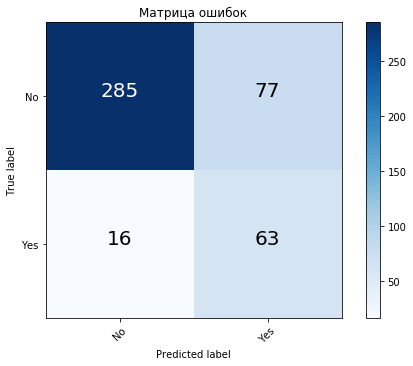

In [22]:
# Матрица ошибок для логистической регрессии.
cnf_matrix = confusion_matrix(y_test, model_log.predict(X_test))
plt.figure(figsize=(7, 5))
plot_confusion_matrix(cnf_matrix, classes=['No', 'Yes'], title='Матрица ошибок')
plt.savefig("conf_matrix.png")
plt.show()

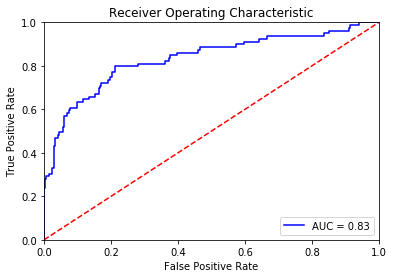

In [23]:
# Roc-Auc для логистической регрессии.
preds = model_log.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig("roc_auc.png")
plt.close()

In [24]:
# Главные признаки.
pos = importance_feat(model=model_log,data=X_train, labels=y_train, into=True, key='coef_')[:10]
neg = importance_feat(model=model_log,data=X_train, labels=y_train, into=True, key='coef_')[21:33]

D:\AnacondaP2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\AnacondaP2\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\AnacondaP2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\AnacondaP2\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


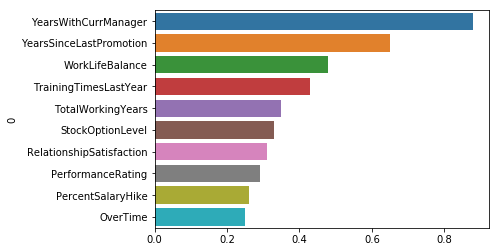

In [25]:
# Главные признаки, которые влияют на то, чтобы 'Attrition' был равен 1.
plot_feat(pos)

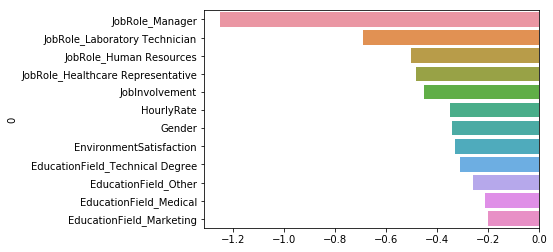

In [26]:
# Главные признаки, которые влияют на то, чтобы 'Attrition' был равен 0.
plot_feat(neg)

# Сбалансированный случайный лес

In [27]:
# Подбор параметров для BRF.
brf = BalancedRandomForestClassifier(n_estimators=1000, random_state=0, bootstrap=True, max_depth=5, max_features=20)
X_train, X_test, y_train, y_test = train_test_split(data_log, labels, test_size=0.3, shuffle=True, random_state=241)

grid = {
        'max_features': [5,20,30],
        'max_depth': [5,10,20,30],
        'n_estimators':[500,800, 1000, 1200]
       }
brf = BalancedRandomForestClassifier(random_state=0, bootstrap=True, n_jobs=multiprocessing.cpu_count())

cv = KFold(n_splits=5, shuffle = True, random_state=241)
gs = GridSearchCV(brf, grid, scoring='balanced_accuracy', cv=cv, verbose=1)
gs.fit(data_log, labels)

print(gs.best_params_) 

In [28]:
#Обучение сбалансированного случайного дерева.

brf.fit(X_train, y_train) 
y_pred = brf.predict(X_test)
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred),'\n') 

print(classification_report(y_test, brf.predict(X_test)))
print('roc_auc:', np.round(roc_auc_score(y_test, brf.predict_proba(X_test)[:,1]),2))

Balanced accuracy: 0.7423246380865794 

              precision    recall  f1-score   support

           0       0.92      0.80      0.86       362
           1       0.43      0.68      0.53        79

   micro avg       0.78      0.78      0.78       441
   macro avg       0.67      0.74      0.69       441
weighted avg       0.83      0.78      0.80       441

roc_auc: 0.79


Confusion matrix, without normalization
[[290  72]
 [ 25  54]]


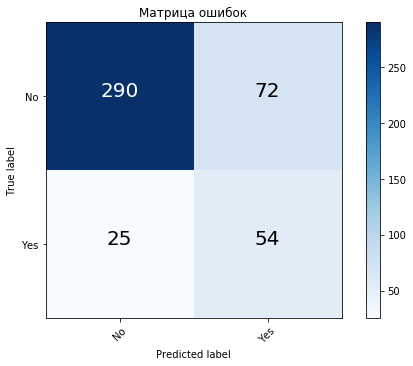

In [29]:
# Матрица ошибок дерева.
cnf_matrix = confusion_matrix(y_test, brf.predict(X_test))
plt.figure(figsize=(7, 5))
plot_confusion_matrix(cnf_matrix, classes=['No', 'Yes'],
                      title='Матрица ошибок')
plt.savefig("conf_matrix.png")
plt.show()

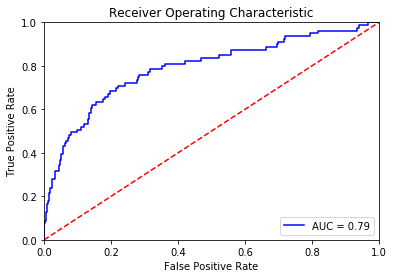

In [30]:
# Roc-Auc для дерева.
preds = brf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.close()

D:\AnacondaP2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\AnacondaP2\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


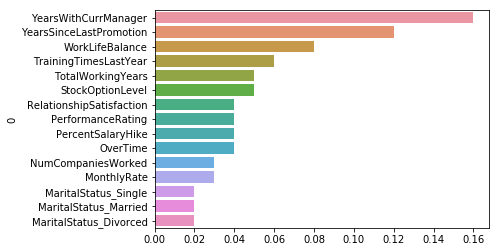

In [31]:
# Главные признаки по версии дерева.
pos = importance_feat(model=brf,data=X_train, labels=y_train, into=False, key='feature_importances_')[:15]
plot_feat(pos)

In [32]:
# Вывод: мы вероятно хотим больше предсказывать наличие истощения сотрудника, нежели его отсутствие.
# Поэтому выбираем соответсвтующую модель(там где больше TP и меньше FN, хоть там и accuracy меньше).

# Прогнозирование брака

In [33]:
data_marriage = data.copy()
data_marriage.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,34,0,Travel_Rarely,628,Research & Development,8,3,Medical,2,1,82,4,2,Laboratory Technician,3,Married,4404,10228,2,0,12,3,1,0,6,3,4,4,3,1,2
1,49,0,Travel_Frequently,1023,Sales,2,3,Medical,4,1,63,2,2,Sales Executive,2,Married,5390,13243,2,0,14,3,4,0,17,3,2,9,6,0,8
2,27,0,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,1,87,4,2,Manufacturing Director,2,Married,6142,5174,1,1,20,4,2,1,6,0,3,6,2,0,3
3,39,0,Travel_Rarely,613,Research & Development,6,1,Medical,4,1,42,2,3,Healthcare Representative,1,Married,9991,21457,4,0,15,3,1,1,9,5,3,7,7,1,7
4,36,0,Travel_Frequently,884,Research & Development,23,2,Medical,3,1,41,4,2,Laboratory Technician,4,Married,2571,12290,4,0,17,3,3,1,17,3,3,5,2,0,3


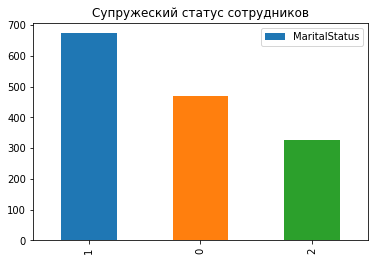

In [34]:
# Кодирование классов.
d = {'Single':0, 
     'Married' : 1, 
     'Divorced' : 2}

data_marriage['MaritalStatus'] = data_marriage['MaritalStatus'].map(d)

# Выборка более-менее сбалансирована.
data_marriage['MaritalStatus'].value_counts().plot(kind='bar', label='MaritalStatus')
plt.legend()
plt.title('Супружеский статус сотрудников');

In [35]:
# Делим на предикторные и целевые переменные.
labels_marriage = data_marriage['MaritalStatus']
data_marriage.drop('MaritalStatus', axis=1, inplace=True)

## Логистическая регрессия

In [36]:
# One-hot кодирование.
data_log_mar = data_marriage.copy()
data_log_mar = pd.get_dummies(data_log_mar)

In [37]:
# Делаем over sampling с помощью SMOTE.
X_train, X_test, y_train, y_test = train_test_split(data_log_mar, labels_marriage, test_size=0.3, shuffle=True, random_state=1)

X_resampled, y_resampled = SMOTE(random_state=241).fit_resample(X_train, y_train)

grid = {'C': [0.1, 1, 5, 10, 20, 50], 
        'solver':['newton-cg', 'lbfgs']}

model_log = LogisticRegression(random_state=241, n_jobs=multiprocessing.cpu_count())

cv = KFold(n_splits=5, shuffle = True, random_state=241)
gs = GridSearchCV(model_log, grid, scoring='balanced_accuracy', cv=cv)

gs.fit(X_resampled, y_resampled)

print(gs.best_params_)

In [38]:
# Обучение лог.регрессии.
model_log = LogisticRegression(C=5, solver='newton-cg')
model_log.fit(X_resampled, y_resampled)

print(classification_report(y_test, model_log.predict(X_test)))
print('balanced accuracy:', np.round(accuracy_score(y_test, model_log.predict(X_test)),2))

D:\AnacondaP2\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\AnacondaP2\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
D:\AnacondaP2\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
D:\AnacondaP2\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\AnacondaP2\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge',

              precision    recall  f1-score   support

           0       0.80      0.94      0.86       136
           1       0.63      0.69      0.66       200
           2       0.48      0.30      0.37       105

   micro avg       0.67      0.67      0.67       441
   macro avg       0.64      0.64      0.63       441
weighted avg       0.65      0.67      0.65       441

balanced accuracy: 0.67


D:\AnacondaP2\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\AnacondaP2\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\AnacondaP2\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\AnacondaP2\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\AnacondaP2\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


Confusion matrix, without normalization
[[128   8   0]
 [ 30 137  33]
 [  3  71  31]]


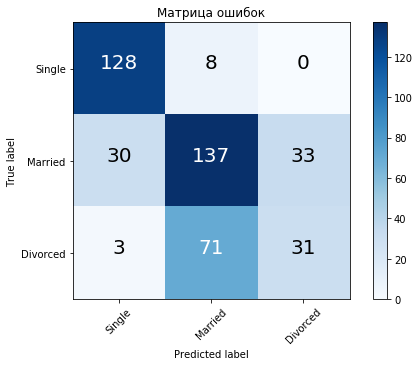

In [39]:
# Матрица ошибок для логистической регрессии.
cnf_matrix = confusion_matrix(y_test, model_log.predict(X_test))
plt.figure(figsize=(7, 5))
plot_confusion_matrix(cnf_matrix, classes=['Single', 'Married', 'Divorced'],
                      title='Матрица ошибок')

plt.savefig("conf_matrix.png")
plt.show()

In [40]:
pos = importance_feat(model_log, data=X_train, labels=y_train, into=True, key='coef_')[:10]
neg = importance_feat(model_log, data=X_train, labels=y_train, into=True, key='coef_')[25:35]


D:\AnacondaP2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\AnacondaP2\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\AnacondaP2\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\AnacondaP2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\AnacondaP2\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by Standa

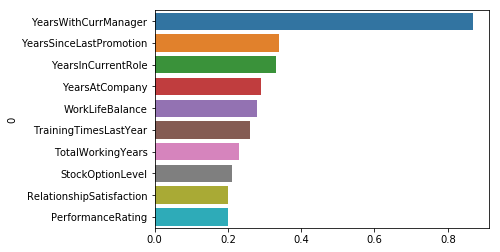

In [41]:
# Главные признаки, которые влияют на то, чтобы 'Attrition' был равен 1.
plot_feat(pos)

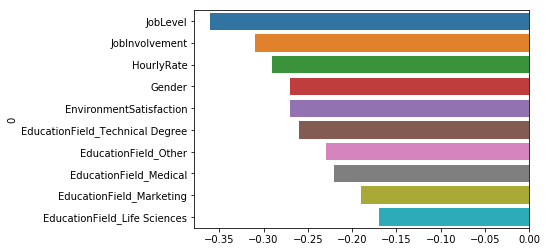

In [42]:
# Главные признаки, которые влияют на то, чтобы 'Attrition' был равен 0.
plot_feat(neg)

## Случайный лес

In [43]:
# C этим преобразованиями качество модели улучшается в среднем на 2%.

data_rf_mar = data_marriage.copy()

d = {'Non-Travel':0, 
     'Travel_Rarely' : 1, 
     'Travel_Frequently' : 2}

data_rf_mar['BusinessTravel'] = data_rf_mar['BusinessTravel'].map(d)

d = {'Research & Development' : 0, 
     'Sales' : 1, 
     'Human Resources' : 2,}
data_rf_mar['Department'] = data_rf_mar['Department'].map(d)

d = {'Medical': 0, 
     'Life Sciences' : 1, 
     'Marketing' : 2, 
     'Other' : 3, 
     'Technical Degree' : 4, 
     'Human Resources':5}

data_rf_mar['EducationField'] = data_rf_mar['EducationField'].map(d)

d = {'Healthcare Representative': 0, 
     'Human Resources' : 1, 
     'Laboratory Technician' : 2,
     'Manager' : 3,
     'Manufacturing Director' : 4, 
     'Research Director':5, 
     'Research Scientist':6, 
     'Sales Executive':7, 
     'Sales Representative':8}

data_rf_mar['JobRole'] = data_rf_mar['JobRole'].map(d)

In [44]:
data_rf_mar.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,34,0,1,628,0,8,3,0,2,1,82,4,2,2,3,4404,10228,2,0,12,3,1,0,6,3,4,4,3,1,2
1,49,0,2,1023,1,2,3,0,4,1,63,2,2,7,2,5390,13243,2,0,14,3,4,0,17,3,2,9,6,0,8
2,27,0,1,155,0,4,3,1,2,1,87,4,2,4,2,6142,5174,1,1,20,4,2,1,6,0,3,6,2,0,3
3,39,0,1,613,0,6,1,0,4,1,42,2,3,0,1,9991,21457,4,0,15,3,1,1,9,5,3,7,7,1,7
4,36,0,2,884,0,23,2,0,3,1,41,4,2,2,4,2571,12290,4,0,17,3,3,1,17,3,3,5,2,0,3


In [45]:
# Подбор параметров для BRF.
brf_mar = BalancedRandomForestClassifier(n_estimators=500, random_state=0, bootstrap=True, max_depth=10, max_features=30)
X_train, X_test, y_train, y_test = train_test_split(data_rf_mar, labels_marriage, test_size=0.3, shuffle=True, random_state=241)

grid = {
        'max_features': [5,20,30],
        'max_depth': [5,10,20,30],
        'n_estimators':[500,800, 1000, 1200]
       }
brf = BalancedRandomForestClassifier(random_state=0, bootstrap=True, n_jobs=multiprocessing.cpu_count())

cv = KFold(n_splits=5, shuffle = True, random_state=241)
gs = GridSearchCV(brf_mar, grid, scoring='balanced_accuracy', cv=cv, verbose=1)
gs.fit(X_train, y_train)

print(gs.best_params_) 

In [46]:
# Обучение модели.

brf_mar.fit(X_train, y_train) 
y_pred = brf_mar.predict(X_test)
print('Balanced accuracy:', np.round(balanced_accuracy_score(y_test, y_pred), 2),'\n') 

print(classification_report(y_test, brf_mar.predict(X_test)))

Balanced accuracy: 0.65 

              precision    recall  f1-score   support

           0       0.71      0.99      0.83       129
           1       0.60      0.26      0.37       194
           2       0.46      0.69      0.55       118

   micro avg       0.59      0.59      0.59       441
   macro avg       0.59      0.65      0.58       441
weighted avg       0.59      0.59      0.55       441



Confusion matrix, without normalization
[[128   1   0]
 [ 49  51  94]
 [  4  33  81]]


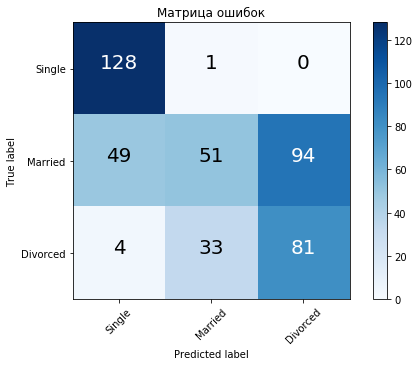

In [47]:
# Помимо всего прочего, видим очень большой недостаток, а именно:
# Делает очень большой акцент на 'Divorced', часто путая его с 'Married.

cnf_matrix = confusion_matrix(y_test, brf_mar.predict(X_test))
plt.figure(figsize=(7, 5))
plot_confusion_matrix(cnf_matrix, classes=['Single', 'Married', 'Divorced'],
                      title='Матрица ошибок')
plt.savefig("conf_matrix.png")
plt.show()

D:\AnacondaP2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\AnacondaP2\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


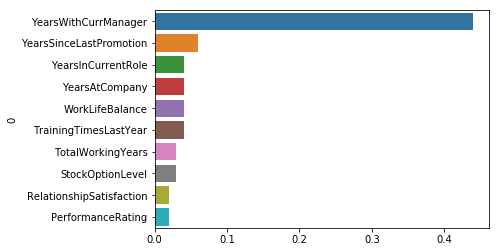

In [48]:
# Главные признаки.
pos = importance_feat(brf_mar, data=X_train, labels=y_train, into=False, key='feature_importances_')[:10]
plot_feat(pos)

In [49]:
# В зависимости от целей, мы выбираем модель.
# Деревья повзоляют нам найти большую часть разведенных людей, однако лог.регрессия находит тех, кто состоит в браке.

# Прогнозирование дохода.

In [50]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,34,0,Travel_Rarely,628,Research & Development,8,3,Medical,2,1,82,4,2,Laboratory Technician,3,Married,4404,10228,2,0,12,3,1,0,6,3,4,4,3,1,2
1,49,0,Travel_Frequently,1023,Sales,2,3,Medical,4,1,63,2,2,Sales Executive,2,Married,5390,13243,2,0,14,3,4,0,17,3,2,9,6,0,8
2,27,0,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,1,87,4,2,Manufacturing Director,2,Married,6142,5174,1,1,20,4,2,1,6,0,3,6,2,0,3
3,39,0,Travel_Rarely,613,Research & Development,6,1,Medical,4,1,42,2,3,Healthcare Representative,1,Married,9991,21457,4,0,15,3,1,1,9,5,3,7,7,1,7
4,36,0,Travel_Frequently,884,Research & Development,23,2,Medical,3,1,41,4,2,Laboratory Technician,4,Married,2571,12290,4,0,17,3,3,1,17,3,3,5,2,0,3


D:\AnacondaP2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


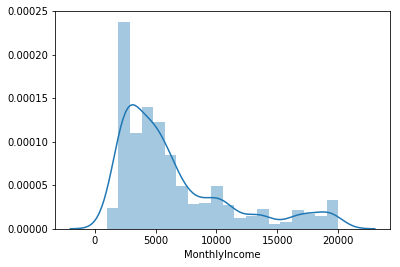

In [51]:
# Расрпеделение целевой перменной.
sbn.distplot(data.MonthlyIncome)

In [52]:
data_income = data.drop('MonthlyIncome', axis=1)
labels_income = data['MonthlyIncome']

# Обычная NN

In [53]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.callbacks import EarlyStopping 

D:\AnacondaP2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [54]:
data_rg_income = data_income.copy()
data_rg_income = pd.get_dummies(data_rg_income)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(data_rg_income, labels_income, test_size=0.4, shuffle=True, random_state=241)

In [56]:
# Для эксперимента - обычная нейронная сеть.

#early_stop = EarlyStopping(monitor='loss')
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()

model.add(Dense(units=20, kernel_initializer='normal', activation='relu', input_dim=49))
model.add(Dense(units=30, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=20, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=20, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.compile(loss='mean_squared_error',optimizer='adam', metrics=['mean_squared_error'])
model.fit(X_train,y_train,epochs=300, batch_size=32, validation_split=0.1)

D:\AnacondaP2\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 793 samples, validate on 89 samples
Epoch 1/300
793/793 [==============================] - 0s 418us/step - loss: 61352580.3279 - mean_squared_error: 61352580.3279 - val_loss: 77962758.7865 - val_mean_squared_error: 77962758.7865
Epoch 2/300
793/793 [==============================] - 0s 46us/step - loss: 61345160.0353 - mean_squared_error: 61345160.0353 - val_loss: 77938430.5618 - val_mean_squared_error: 77938430.5618
Epoch 3/300
793/793 [==============================] - 0s 44us/step - loss: 61265343.4805 - mean_squared_error: 61265343.4805 - val_loss: 77717996.8539 - val_mean_squared_error: 77717996.8539
Epoch 4/300
793/793 [==============================] - 0s 42us/step - loss: 60765194.5523 - mean_squared_error: 60765194.5523 - val_loss: 76520703.0112 - val_mean_squared_error: 76520703.0112
Epoch 5/300
793/793 [==============================] - 0s 49us/step - loss: 58587334.3405 - mean_squared_error: 58587334.3405 - val_loss: 72115170.3371 - val_mean_squared_error: 72115170

793/793 [==============================] - 0s 39us/step - loss: 2318591.7563 - mean_squared_error: 2318591.7563 - val_loss: 3140635.8427 - val_mean_squared_error: 3140635.8427
Epoch 44/300
793/793 [==============================] - 0s 40us/step - loss: 2252017.7360 - mean_squared_error: 2252017.7360 - val_loss: 3020050.2556 - val_mean_squared_error: 3020050.2556
Epoch 45/300
793/793 [==============================] - 0s 45us/step - loss: 2166837.4338 - mean_squared_error: 2166837.4338 - val_loss: 2902042.3146 - val_mean_squared_error: 2902042.3146
Epoch 46/300
793/793 [==============================] - 0s 47us/step - loss: 2089729.8796 - mean_squared_error: 2089729.8796 - val_loss: 2810574.3511 - val_mean_squared_error: 2810574.3511
Epoch 47/300
793/793 [==============================] - 0s 42us/step - loss: 2031170.5810 - mean_squared_error: 2031170.5810 - val_loss: 2691002.4972 - val_mean_squared_error: 2691002.4972
Epoch 48/300
793/793 [==============================] - ETA: 0s - lo

793/793 [==============================] - 0s 40us/step - loss: 1346860.8460 - mean_squared_error: 1346860.8460 - val_loss: 1560182.1152 - val_mean_squared_error: 1560182.1152
Epoch 87/300
793/793 [==============================] - 0s 47us/step - loss: 1343442.4970 - mean_squared_error: 1343442.4970 - val_loss: 1612458.5393 - val_mean_squared_error: 1612458.5393
Epoch 88/300
793/793 [==============================] - 0s 47us/step - loss: 1347865.2829 - mean_squared_error: 1347865.2829 - val_loss: 1565114.4438 - val_mean_squared_error: 1565114.4438
Epoch 89/300
793/793 [==============================] - 0s 44us/step - loss: 1332205.7183 - mean_squared_error: 1332205.7183 - val_loss: 1528506.9073 - val_mean_squared_error: 1528506.9073
Epoch 90/300
793/793 [==============================] - 0s 49us/step - loss: 1329145.3662 - mean_squared_error: 1329145.3662 - val_loss: 1599244.8848 - val_mean_squared_error: 1599244.8848
Epoch 91/300
793/793 [==============================] - 0s 48us/step

793/793 [==============================] - 0s 49us/step - loss: 1135645.8319 - mean_squared_error: 1135645.8319 - val_loss: 1429102.1938 - val_mean_squared_error: 1429102.1938
Epoch 130/300
793/793 [==============================] - 0s 44us/step - loss: 1126072.5405 - mean_squared_error: 1126072.5405 - val_loss: 1340112.8624 - val_mean_squared_error: 1340112.8624
Epoch 131/300
793/793 [==============================] - 0s 39us/step - loss: 1119204.1885 - mean_squared_error: 1119204.1885 - val_loss: 1301855.8834 - val_mean_squared_error: 1301855.8834
Epoch 132/300
793/793 [==============================] - 0s 48us/step - loss: 1120827.0745 - mean_squared_error: 1120827.0745 - val_loss: 1320024.6334 - val_mean_squared_error: 1320024.6334
Epoch 133/300
793/793 [==============================] - 0s 40us/step - loss: 1110272.0525 - mean_squared_error: 1110272.0525 - val_loss: 1330596.2416 - val_mean_squared_error: 1330596.2416
Epoch 134/300
793/793 [==============================] - 0s 42us

793/793 [==============================] - 0s 43us/step - loss: 1004594.6865 - mean_squared_error: 1004594.6865 - val_loss: 1228117.0421 - val_mean_squared_error: 1228117.0421
Epoch 173/300
793/793 [==============================] - 0s 40us/step - loss: 1013593.8329 - mean_squared_error: 1013593.8329 - val_loss: 1253814.1882 - val_mean_squared_error: 1253814.1882
Epoch 174/300
793/793 [==============================] - 0s 39us/step - loss: 1002446.4367 - mean_squared_error: 1002446.4367 - val_loss: 1230903.3371 - val_mean_squared_error: 1230903.3371
Epoch 175/300
793/793 [==============================] - 0s 42us/step - loss: 1016616.0771 - mean_squared_error: 1016616.0771 - val_loss: 1262140.9691 - val_mean_squared_error: 1262140.9691
Epoch 176/300
793/793 [==============================] - 0s 43us/step - loss: 1020015.2142 - mean_squared_error: 1020015.2142 - val_loss: 1240245.0295 - val_mean_squared_error: 1240245.0295
Epoch 177/300
793/793 [==============================] - 0s 43us

793/793 [==============================] - 0s 43us/step - loss: 948838.8650 - mean_squared_error: 948838.8650 - val_loss: 1207043.5997 - val_mean_squared_error: 1207043.5997
Epoch 216/300
793/793 [==============================] - 0s 45us/step - loss: 944322.4700 - mean_squared_error: 944322.4700 - val_loss: 1203949.8525 - val_mean_squared_error: 1203949.8525
Epoch 217/300
793/793 [==============================] - 0s 42us/step - loss: 942461.0093 - mean_squared_error: 942461.0093 - val_loss: 1212517.8118 - val_mean_squared_error: 1212517.8118
Epoch 218/300
793/793 [==============================] - 0s 45us/step - loss: 956908.6981 - mean_squared_error: 956908.6981 - val_loss: 1249910.3975 - val_mean_squared_error: 1249910.3975
Epoch 219/300
793/793 [==============================] - 0s 39us/step - loss: 943720.0905 - mean_squared_error: 943720.0905 - val_loss: 1229293.6545 - val_mean_squared_error: 1229293.6545
Epoch 220/300
793/793 [==============================] - 0s 41us/step - lo

Epoch 259/300
793/793 [==============================] - 0s 38us/step - loss: 926749.7777 - mean_squared_error: 926749.7777 - val_loss: 1200990.8469 - val_mean_squared_error: 1200990.8469
Epoch 260/300
793/793 [==============================] - 0s 42us/step - loss: 916940.2587 - mean_squared_error: 916940.2587 - val_loss: 1199884.4607 - val_mean_squared_error: 1199884.4607
Epoch 261/300
793/793 [==============================] - 0s 42us/step - loss: 912234.4247 - mean_squared_error: 912234.4247 - val_loss: 1186486.7542 - val_mean_squared_error: 1186486.7542
Epoch 262/300
793/793 [==============================] - 0s 47us/step - loss: 913234.1871 - mean_squared_error: 913234.1871 - val_loss: 1197786.1728 - val_mean_squared_error: 1197786.1728
Epoch 263/300
793/793 [==============================] - 0s 39us/step - loss: 908851.7491 - mean_squared_error: 908851.7491 - val_loss: 1193812.9719 - val_mean_squared_error: 1193812.9719
Epoch 264/300
793/793 [==============================] - 0s 

In [58]:
print('R2:', r2_score(y_test, model.predict(X_test)))

R2: 0.9438468983059269


In [59]:
print('MAE:', metrics.mean_absolute_error(y_test, model.predict(X_test)))

MAE: 857.3628853518946


D:\AnacondaP2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


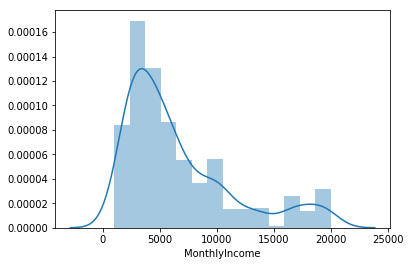

In [60]:
# Распределение тестовой выборки.
sbn.distplot(y_test)

D:\AnacondaP2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


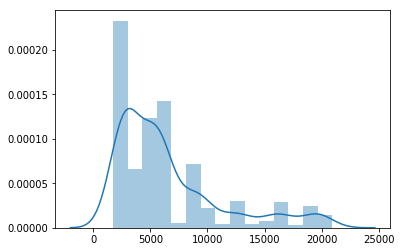

In [61]:
# Распределение модели на тестовой выборке.
sbn.distplot(model.predict(X_test))